# GNNExplainer

By Steffan Paul (steffanbpaul@gmail.com)

In [1]:
import numpy as np
from scipy.special import comb
import sys, os
import pandas as pd
import time as time
from sklearn import metrics
import matplotlib as mpl
import matplotlib.pyplot as plt
import time as time

#set random seed
np.random.seed(274)

#PyTorch
import torch 
import torch.nn as nn
import torch.optim as optim

#Pytorch Geometric modules
from torch_geometric.nn import GCNConv, GATConv, MessagePassing
from torch_geometric import utils
import torch_geometric.transforms as T
from torch_scatter import scatter
from torch_geometric.data import GraphSAINTRandomWalkSampler
from torch_geometric.data import Data

#networkx
import networkx as nx

Explainable AI (XAI) is a growing field of research. As Neural Networks become more prevalant in real-world applications, it is increasingly important that methods are developed to interpret a model's black box to ensure that it is trustworthy and safe for use. Futhermore, XAI methods can be used to learn new insights about our data by interpreting the model's process.

One such method developed for explaining Graph Neural Network models is GNNExplainer ([Ying et al, 2019](https://arxiv.org/abs/1903.03894)). GNNExplainer takes in any trained GNN model and identifies a subgraph around a single node that explains an individual prediction (node, graph or edge prediction). It does this by learning a mask over the adjacency matrix of the node's neighborhood. The optimization of the mask is carried out by maximizing the mutual information between the prediction and the distribution of graph substructures. GNNExplainer also learns a mask over the node feature matrix to highlight important features for the prediction.

In this tutorial, we will walk through how GNNExplainer works using code based on an implementation in [pytorch geometric](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.models.GNNExplainer), and implement it to see what the resulting explanations look like. Before we get to GNNExplainer we will briefly walk through the data preparation and model training for a dataset of protein-protein interactions. 

Overall, this tutorial will cover the following:

1. Importing and preparing a dataset for modelling
2. Training a GNN on the data
3. Implementing GNNExplainer
4. Explaining a prediction and visualizing the explanation

## 1. The Data

For this tutorial, we will use the [ogbn-proteins dataset](https://ogb.stanford.edu/docs/nodeprop/) from the Open Graph Benchmark (OGB). This data was constructed by the authors of OGB using the STRING database. More info about the database can be found here: ["STRING v11", Szklarcyz et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6323986/).

The nodes of this graph are proteins of different species. Edges between the nodes denote some connection between these proteins. There are 8 edge types for different kinds of connections:

- 1 Homology: homologous proteins in different species
- 2 Neighborhood, 3 Fusion, 4 Cooccurence: genomic analyses suggest a pair of proteins are related via genomic rearrangements across evolution.
- 5 Coexpression: correlation of gene expression from transcriptomics and proteomics
- 6 Experimental: protein-protein interactions found from experiments
- 7 Database: manually curated interaction records
- 8 Textmining: Analysis of literature databases looking for co-citation of the proteins

The data is accompanied by [Gene Ontology (GO)](http://geneontology.org/docs/ontology-documentation/) annotation labels. The label matrix includes 112 GO annotations (a multi-label prediction problem).

## Import and process the data


It is easy to import an OGB dataset into a pytorch geometric (PyG) dataset object which includes a lot of functionality. Now we will import the data and use the transforms module from PyG to immediately import it as a Sparse Tensor. A Sparse Tensor is like an edge list (only non-zero edges are included as pairs) but can be indexed like an adjacency matrix. This will make it easier to index later.

In [2]:
#Now we will import the data
from ogb.nodeproppred import PygNodePropPredDataset

dataset = PygNodePropPredDataset(name='ogbn-proteins', root='dataset',
                                     transform=T.ToSparseTensor())
#this will download the data into a created dataset folder in your current dir.
data = dataset[0] #each dataset object can contain multple graphs. Here we only have one graph

In [3]:
#Let's take a look at what the data looks like
print (data) #gives a summary of the graph
#some added elucidation
print ('Number of nodes: {}'.format(data.num_nodes))
print ('Number of edges: {}'.format(data.adj_t.nnz()))
print ('Number of species in graph: {}'.format(data.node_species.unique().shape[0]))
print ('Number of edge types: {}'.format(data.adj_t.size(2)))
print ('Number of Y labels: {}'.format(data.y.shape[1]))
print ('Sparsity of graph: {:.3f}'.format(data.adj_t.nnz() / comb(data.num_nodes, 2)))

Data(adj_t=[132534, 132534, 8, nnz=79122504], node_species=[132534, 1], y=[132534, 112])
Number of nodes: 132534
Number of edges: 79122504
Number of species in graph: 8
Number of edge types: 8
Number of Y labels: 112
Sparsity of graph: 0.009


As we can see the graph is decently large. For the purposes of learning about GNNExplainer we can trim it down to make it easier to use.

Notice that the graph contains proteins from 8 different species. Let's just extract the graph of **human proteins**. To do this we will make use of the mapping files provided in the data download (under /dataset/mapping).

#### Make the Edge list

In [4]:
#the mappings for the node protein and species identity
node_maps = pd.read_csv('dataset/ogbn_proteins/mapping/nodeidx2proteinid.csv.gz')

#the table includes the columns: (node_idx, protein id)
#The protein id column includes the species TaxID
#and the protein ensembl ID separated by a dot.

#Use pandas regex functionality to split up the information
node_maps = pd.concat([node_maps, node_maps['protein id'].str.split(pat='\.', n=1, expand=True)], axis=1)
node_maps = node_maps.rename(columns={0:'TaxID', 1:"Protein"})
node_maps.head()

,node idx,protein id,TaxID,Protein
0,0,3702.AT1G01010.1,3702,AT1G01010.1
1,1,3702.AT1G10570.1,3702,AT1G10570.1
2,2,3702.AT1G06149.1,3702,AT1G06149.1
3,3,3702.AT1G17080.1,3702,AT1G17080.1
4,4,3702.AT1G18340.1,3702,AT1G18340.1


In [5]:
#now get the indices corresponding to human proten nodes
human_taxID = '9606'
human_idx = node_maps['node idx'][node_maps['TaxID'] == human_taxID].values
human_idx = torch.from_numpy(human_idx)

print ('Number of human proteins: {}'.format(len(human_idx)))

Number of human proteins: 19354


As you can see, there are much fewer human proteins than total nodes in the graph. 

In [6]:
#with this index we can extract the edge lists from the full sparse adjacency matrix
data.adj_t

SparseTensor(row=tensor([     0,      0,      0,  ..., 132533, 132533, 132533]),
             col=tensor([     1,      2,      3,  ...,  98734, 102639, 132517]),
             val=tensor([[0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
                           [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.8660],
                           [0.0010, 0.0010, 0.0010,  ..., 0.7630, 0.0010, 0.0010],
                           ...,
                           [0.5010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
                           [0.5010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
                           [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010]]),
             size=(132534, 132534, 8), nnz=79122504, density=0.45%)

In [7]:
#We can also select which edge types we want (i.e the val tensor in the Sparse Object)
#For now let's use all of them
use_edge_types = torch.arange(data.adj_t.size(2))

#extract the sub matrix for all the human nodes and edge types of interest
hum_adj = data.adj_t[human_idx, human_idx, use_edge_types]

#convert the sparse representation to long edge lists by accessing the row and col tensors
hum_edge_index = torch.stack([hum_adj.storage.row() , hum_adj.storage.col()])
print ('Edge list:')
print (hum_edge_index)

#also extract the edge types as a matrix in the shape (num_edges x num_edge_types)
hum_edge_attr = hum_adj.storage.value()
print ('Edge type matrix:')
print (hum_edge_attr)

Edge list:
tensor([[    0,     0,     0,  ..., 19351, 19352, 19353],
        [    1,     2,     3,  ...,  9106, 16501, 19282]])
Edge type matrix:
tensor([[0.0010, 0.0010, 0.0010,  ..., 0.1820, 0.0010, 0.1260],
        [0.0010, 0.0010, 0.0010,  ..., 0.1870, 0.0010, 0.0570],
        [0.0010, 0.0010, 0.0010,  ..., 0.1600, 0.0010, 0.0010],
        ...,
        [0.0010, 0.0010, 0.0010,  ..., 0.1820, 0.0010, 0.0010],
        [0.0010, 0.0010, 0.0010,  ..., 0.3800, 0.0010, 0.0550],
        [0.0010, 0.0010, 0.0010,  ..., 0.2380, 0.0010, 0.0010]])


#### Extract Largest Connected Component (LCC)
For graph learning tasks, it is best practice to operate on the LCC of the data. The easiest way to extract this is usuing *networkx*.

In [8]:
#construct a temporary data object
temp_data = Data(edge_index = hum_edge_index, num_nodes = len(human_idx))
#convert to networkx format
nx_data = utils.to_networkx(temp_data, to_undirected=True)

#get the lists of conected components
connected_components = list(nx.connected_components(nx_data))
print(f"Graph contains {len(connected_components)} connected components")

Graph contains 1 connected components


It appears that the human subgraph is already completely connected, so we don't need to change our indices. Please See *Tutorial 05 graph-attention* for an example of how you would index into an edge list to extract the LCC if it wasn't already connected.

#### Make some node features

Note that this data doesn't come with node features to use as initial embeddings. We could use one-hot encoding of the nods, but with ~20k nodes, it will be easier to have a smaller dimensional feature matrix. 

An easy way to create this is to aggregate the edge type information into some node features. Each edge comes with 8 scores corresponding to the confidence of each connection type. For each node, let's take the mean value of the scores of all the edges connected to that node, for each edge type, i.e for node $i$ and for the $t^{th}$ feature value: 

$$ \forall t \in T , X_i^t = \frac{1}{|N_i|} \sum_{j \in N_i} e_{i,j}^t $$

Where $T$ is the set of edge types, $N_i$ is the neighborhood of node $i$ and $e_{i,j}$ is the vector of scores for the edge between $i$ and $j$. Resulting in a (num_nodes x num_edge_types) feature matrix $X$.

In [9]:
X_feat = data.adj_t.mean(dim=1)

#extract the human rows from the feature matrix
hum_X = X_feat[human_idx, :]

#### Select the prediction labels

To make our downstream analysis simpler, let's just select one label for the node prediction task. The mappings for the labels are also present in the mappings folder.

In [10]:
#open the label mappings
lab_map = pd.read_csv('dataset/ogbn_proteins/mapping/labelidx2GO.csv.gz')

#the labels are indexed by GO IDs. To make selection a bit easier I've included a
#table of GO Terms indexed by their IDs. This was constructed using the bioconductor package in R.
goterms = pd.read_csv('goID_terms.tsv', sep='\t')

#add the term to the label idx
lab_map['Term'] = pd.Series([goterms['Term'][goterms['GO_ID'] == gi].item() for gi in lab_map['GO']])

print (lab_map.head())

   label idx          GO                                 Term
0          0  GO:0003674                   molecular_function
1          1  GO:0009987                     cellular process
2          2  GO:0005488                              binding
3          3  GO:0071704  organic substance metabolic process
4          4  GO:0044237           cellular metabolic process


In [11]:
#I selected a term that is approximately equally distributed within the human nodes
#You can verify this is true as an additional task
label_oi = 'regulation of cellular process'
labels_idx = torch.tensor(lab_map['label idx'][lab_map['Term'] == label_oi].item())

#extract the human rows of the label matrix and the selected column
hum_Y = data.y[human_idx][:, labels_idx].float()
#because we're only selecting one column we need to reshape the matrix to retain its 2 dimensions
hum_Y = hum_Y.unsqueeze(1)

#### Put the data object together
Now we are ready to construct a Pytorch Geometric Data object for modelling. 

In [12]:
hum_graph = Data(edge_index=hum_edge_index,
                 edge_attr=hum_edge_attr,
                 y= hum_Y,
                 node_species=data.node_species[human_idx,:], #select the human rows from the node_species
                 x = hum_X
                )

#we also need to create a training split. 
from helper_functions import make_training_split

#Make the split masks
split_frac = {'train': 0.7, 'val':0.1}
split_masks = make_training_split(np.arange(hum_graph.num_nodes) , split_frac, hum_graph.y, hum_graph.num_nodes)

#add to graph
hum_graph.train_mask = split_masks['Train']
hum_graph.val_mask = split_masks['Val']
hum_graph.test_mask = split_masks['Test']

#Now the graph object is complete!
print (hum_graph)

Data(edge_attr=[11759454, 8], edge_index=[2, 11759454], node_species=[19354, 1], test_mask=[19354], train_mask=[19354], val_mask=[19354], x=[19354, 8], y=[19354, 1])


## 2. Train a GNN on this data

Now that we have processed our data, we are ready to train a GNN model to use as a candidate to generate explanations. We perform batch learning using GraphSAINT as a batch generator. Most of the code for training and the Learner class comes from Tutorial 01, so please check that out for more on training different GNN architectures.

In [13]:
#Set hyper parameters
class Hyperparameters():
    def __init__(self):
        self.num_node_features = None
        self.num_classes = None
        self.lr = 0.01
        self.w_decay = 0   
        self.dropout = 0.5
        self.epochs = 2
        self.log_step = 10 #increments of epochs to wait before reporting performance
        self.cuda = True                
        self.device  =  None
        self.GraphSAINT = None

#initialize parameters
args = Hyperparameters()
args.num_node_features = hum_graph.num_node_features
args.num_classes = hum_graph.y.shape[1]
args.cuda = args.cuda and torch.cuda.is_available() 
if args.cuda:
    args.device = torch.device('cuda') 
else:
    args.device = torch.device('cpu')
    
#add parameters for the GraphSAINT batch generator
args.GraphSAINT = {'batch_size': 256,
                  'walk_length': 16,
                  'num_steps': 64}

In [14]:
#Design GNN Architecture
#For this tutorial we will use a simple Graph Attention Network (See Tutorial 05 for more details)
#See Tutorial 01 for other possible architectures

class GNN(torch.nn.Module):
    def __init__(self): 
        super(GNN, self).__init__()
        self.conv1 = GATConv(args.num_node_features, 32, heads=8)
        self.conv2 = GATConv(256, args.num_classes, heads=1)
        self.transition = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(p=args.dropout)
        )

    def forward(self, x, edge_index): 
        x = self.conv1(x, edge_index)
        x = self.transition(x)
        x = self.conv2(x, edge_index)
        return x

#### Train the model

*NOTE: Training a model of this size on this data definitely requires a gpu. This tutorial is not primarily about training models, so I have also provided a trained model in the model_params/ folder of this tutorial. If you wish you can skip the next two blocks and load that pretrained model.*

In [ ]:
#Import the Learner class from helper_functions. Please see that file and Tutorial 01 for details
from helper_functions import LearnGraphSAINT

#initiate new learner
learner = LearnGraphSAINT(model=GNN(), graph=hum_graph, args=args)

auc = learner.test_cpu()
print('Test ROC-AUC: {:.1%}'.format(auc[0]))

#### Save model parameters for easy loading later

In [ ]:
#an easy way to save a pytorch model is to save the state parameters of the model
#the model can easily be loaded on to a model() object with equilavent architecture

#define a path for the parameters
params_folder = 'model_params'
model_name = 'GAT_1'
if not os.path.isdir(params_folder):
    os.makedirs(params_folder)
    print ('Making {}'.format(params_folder))
    
#save the model
save_path = '{}.pt'.format(os.path.join(params_folder, model_name))
torch.save(learner.model.state_dict(), save_path)

## 3. Implement GNNExplainer

Now that we have a trained model, we can get explanations for predictions. We will implement GNNExplainer step by step to give you a deeper understanding into how it works. The code for this section is largely based on the [implementation of GNNExplainer in Pytorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/models/gnn_explainer.html). At the end of this section we will implement GNNExplainer again using easy PyG code. 

In [16]:
#First we'll load in model parameters in case we already trained a model
params_folder = 'model_params'
model_name = 'GAT_params'
load_path = '{}.pt'.format(os.path.join(params_folder, model_name))
load_model = GNN()
load_model.load_state_dict(torch.load(load_path))

#set the model to evaluation mode
load_model.eval()

GNN(
  (conv1): GATConv(8, 32, heads=8)
  (conv2): GATConv(256, 1, heads=1)
  (transition): Sequential(
    (0): ReLU()
    (1): Dropout(p=0.5, inplace=False)
  )
)

First lets select the node we want to explain 

In [17]:
#retrieve the mappings for the human nodes
human_maps = node_maps.iloc[human_idx.numpy()].reset_index()

#the proteins are labelled by their ENSEMBL ID. You can search for
#your protein of interest's ID on Uniprot or String-db
goi = 'ENSP00000480583'
node_idx = human_maps.index[human_maps['Protein'] == goi].item()
#you can also select an arbitrary node to explain using the indices

print ('Node to explain: {}'.format(node_idx))


Node to explain: 13112


To make the optimization easy we only need to operate on a small k-hop subgraph around the explained node. As there are only two layers in our GNN, we could operate on the 2-hop subgraph. However, because this graph is quite densely connected, even a 2-hop subgraph around a single node expands to thousands of nodes. So for simplicity we will work with just the 1-hop neighborhood of the node.

In [18]:
from torch_geometric.utils import k_hop_subgraph

num_hops = 1

#extract the full x and edge list from the graph
x, edge_index = hum_graph.x, hum_graph.edge_index

subset, sub_edge_index, mapping, hard_edge_mask = k_hop_subgraph(
            node_idx, num_hops, edge_index, relabel_nodes=True,
            num_nodes=x.size(0))
sub_x = x[subset]

#we'll use the hard_edge_mask later to reconstruct the edge mask
#the mapping will be used later to select for the logit of the explained node

This produces a smaller feature matrix (sub_x) and edge list (sub_edge_index) that the GNN can operate on. (*Task: Look into the shapes of the other resulting objects to see what those correspond to.*)

The main output of GNNExplainer is an edge mask ($\sigma(M), M \in R^{n \times n}$ or when using edge lists instead of adjacency matrices, $M \in R^{E}$ where $E$ is the number of edges) and a feature mask ($F \in R^{f}$ where $f$ is the number of features). These mask matrices are optimized by minimizing the loss function: 

$$ loss = - \log P(Y=y|G=A_c \odot \sigma(M), X= X_c \odot F) $$

First we will initialize the matrices for the masks ($M$ and $F$):

In [19]:
sub_num_edges = sub_edge_index.size(1)
sub_num_nodes, num_features = sub_x.size()

#this is an initialization trick that increases optimization performance
std = torch.nn.init.calculate_gain('relu') * np.sqrt(2.0 / (2 * sub_num_nodes))

edge_mask = torch.nn.Parameter(torch.randn(sub_num_edges) * std)
node_feat_mask = torch.nn.Parameter(torch.randn(num_features) * 0.1)

#### A quick note about message passing in PyG and its implications here:

GNN architectures are easily implemented in PyG using the MessagePassing module. When defining the model's forward pass function, the MessagePassing.propagate() function is called which calls on the message() and aggregate() funcions of the model to aggregate embeddings of a node's neighbors in each layer. In the default MessagePassing functionality, the GNN class accepts an edge list made up of integer indices of the paired nodes which is a great object for using scatter functions to efficiently aggregate node embeddings. See Tutorial 05 for more details on what PyG is doing under the hood.

However, in GNNExplainer, the adjacency matrix is masked, turning the elements into real numbers which cannot be formulated as an edge list. Thus we cannot merely mask our edgelist and pass it to our model as is. Luckily, PyG has built in functionality which recognizes if a model is being used for explanation. So you can pass in an edge mask and the integer edge list separately and then PyG masks the edges internally before message propagation. See the [MessagePassing source code](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/conv/message_passing.html#MessagePassing.propagate) for more details.

In [20]:
#To tell PyG that a model is being used for explanation
#we set the following on each layer in the model
for module in load_model.modules():
    if isinstance(module, MessagePassing):
        module.__explain__ = True
        #And we add the edge_mask to each layer's module object
        module.__edge_mask__ = edge_mask


Now the model will mask the edges at each layer and the parameters wil be trained over the epochs.

Now let's define a function to calculate the loss. The primary part of the loss function is calculated by doing a feed-forward pass over the graph to get the logit.

In addition to the loss function written above, many regularization terms are added to the optimization to enforce a useful explanation. This includes 1) element-wise entropy of the masks to enforce discreteness. 2) sum of all elements, to penalize large explanations. These terms are modulated by lagrange multipliers which can be changed manually. 

In [21]:
coeff = {'edge_entropy_term': 1.0,
        'feat_entropy_term': 0.1,
        'edge_size': 0.005,
        'feat_size': 1.0}

def explain_loss(logit, edge_mask, node_feat_mask, coeff):
    loss = -logit
    
    #take the sigmoid of the mask to get in [0,1]
    m = edge_mask.sigmoid()
    #add the sum of the mask elements to the loss
    loss = loss + coeff['edge_size'] * torch.sum(m)
    #calculate the element-wise entropy of the mask values
    #(low entropy implies a discrete variable - close to 1 or 0)
    entropy = -m * torch.log(m + 1e-15) - (1-m) * torch.log(1 -m + 1e-15)
    loss = loss + coeff['edge_entropy_term'] * entropy.mean()
    
    m = node_feat_mask.sigmoid()
    loss = loss + coeff['feat_size'] * torch.sum(m)
    entropy = -m * torch.log(m + 1e-15) - (1-m) * torch.log(1 -m + 1e-15)
    loss = loss + coeff['feat_entropy_term'] * entropy.mean()
    
    return (loss)

Define the optimizer which will optimize the parameters in the mask:

In [22]:
optimizer = torch.optim.Adam([node_feat_mask, edge_mask], lr=0.01)

Now we are ready to train the masks. We will also use a tqdm logger to keep track of progress.

In [23]:
from tqdm import tqdm

num_epochs = 200

#progress bar
pbar = tqdm(total=num_epochs)
pbar.set_description('Explain node {}'.format(node_idx))

#train
for epoch in range(1, num_epochs + 1):
    optimizer.zero_grad()
    #mask the feature matrix 
    h = sub_x * node_feat_mask.view(1, -1).sigmoid()
    #calculate the logit value by forward-pass
    logits = load_model(x=h, edge_index=sub_edge_index)
    logit = logits[mapping]
    #calculate regularized loss
    loss = explain_loss(logit, edge_mask, node_feat_mask, coeff)
    loss.backward()
    optimizer.step()
    
    pbar.update(1)

pbar.close()

#extract the trained edge mask
#we want the edge_mask to be in the shape of the full number of edges
#not the subgraph we constructed
final_edge_mask = edge_mask.new_zeros(hum_graph.num_edges) #tensor in shape of full graph
final_edge_mask[hard_edge_mask] = edge_mask.detach().sigmoid()
#clear from the model
for module in load_model.modules():
            if isinstance(module, MessagePassing):
                module.__explain__ = False
                module.__edge_mask__ = None
edge_mask = None

#the feature mask is a bit simpler
final_node_feat_mask = node_feat_mask.detach().sigmoid()
node_feat_mask = None


Explain node 13112: 100%|██████████| 200/200 [00:01<00:00, 151.86it/s]


In [24]:
print ('Edge mask shape:')
print (final_edge_mask.shape)
print ('Feature mask shape:')
print (final_node_feat_mask.shape)


Edge mask shape:
torch.Size([11759454])
Feature mask shape:
torch.Size([8])


As we can see the output of the explanation are two masks in the shape of the number of edges for the edge mask and the number of features for the node feature mask. If you look into the edge mask you'll notice it is zero everywhere except for edges included in the subgraph around the explained node. For the nonzero edges they occupy a value between \[0,1\] that determines their contribution for the explanation.

### Pytorch Geometric implementation

It was useful to go through GNNExplainer step by step, but Pytorch Geometric also includes a very easy implementation:

In [25]:
from torch_geometric.nn import GNNExplainer

#initialize an explainer class
explainer = GNNExplainer(load_model, epochs=200, num_hops = 1)

#pick the node to explain again
goi = 'ENSP00000480583'
node_idx = human_maps.index[human_maps['Protein'] == goi].item()

print ('Node to explain: {}'.format(node_idx))

#get explanation
node_feat_mask, edge_mask = explainer.explain_node(node_idx, hum_graph.x, hum_graph.edge_index)

Node to explain: 13112


Explain node 13112: 100%|██████████| 200/200 [00:01<00:00, 174.36it/s]


In [26]:
print ('Edge mask shape:')
print (edge_mask.shape)
print ('Feature mask shape:')
print (node_feat_mask.shape)

Edge mask shape:
torch.Size([11759454])
Feature mask shape:
torch.Size([8])


To get a quick confirmation that our implementation works just as well, let's look at the distribution of scores for both edge_masks (remember to only look at the edges of the subgraph).

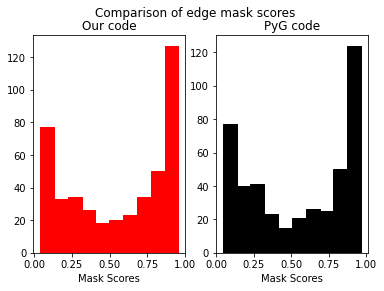

In [29]:
fig, axs = plt.subplots(1,2, figsize=(6,4))
fig.suptitle('Comparison of edge mask scores')
axs[0].hist(final_edge_mask[hard_edge_mask].numpy(), color='r', ec='r')
axs[0].set_title('Our code')
axs[0].set_xlabel('Mask Scores')
axs[1].hist(edge_mask[hard_edge_mask].numpy(), color='k', ec='k')
axs[1].set_title('PyG code')
axs[1].set_xlabel('Mask Scores')
plt.show()

## 4. Visualize subgraph explanation

Now that we've successfully gotten an explanation we need to visualize it in such a way that we can interpret. A first step is to visualize the subgraph surrounding the explained node showing the included edges. 

To select the included edges you will have to select a threshold of mask scores, above which the edges are included. Looking at the histogram above we could say that 0.5 seems to divide the edges well. Another option is to visualize all the edges with their transparency weighted by the score. 

PyG includes some code to visualize their subgraphs:

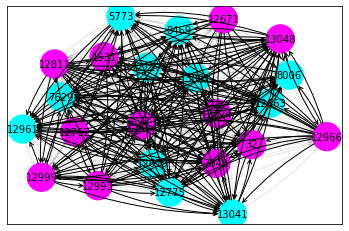

In [30]:
#set threshold
thresh = 0.5

ax, G = explainer.visualize_subgraph(node_idx, hum_graph.edge_index, edge_mask,
                                     y=hum_graph.y,
                                     threshold=thresh)
plt.show()

Hmm this plot is a little difficult to understand. The main reason here is that at this threshold most of the edges are included in the explanation. Looking at the histogram above, this is in fact half of the edges. And remember that this graph is super dense, so that's a lot of edges to plot. You could try increasing the threshold to plot only more important edges.

Maybe we can also improve on the plotting to help the figure. Below is some code based on the PyG visualize_subgraph function, but with some modifications.

In [31]:
def visualize_custom(node_idx, edge_index, edge_mask, y, num_hops=1,
                     labs=False, cmap_code='cool', plot_central=False, exp_thresh=0.5):

    r"""Visualizes the subgraph around an explained node

        Args:
            node_idx (int): The node id to explain.
            edge_index (LongTensor): The edge indices.
            edge_mask (Tensor): The edge mask.
            y (Tensor): The ground-truth node-prediction labels used
                as node colorings. (default: :obj:`None`)
            num_hops (float) : The number of steps around the explained node
                                to include in the subgraph
                
            labs (bool) : whether to plot node labels on top of the network
            cmap_code (str) : which matplotlib color map to use see (https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)
            plot_central (bool) : whether to only plot the edges connected to the "central"
                                    explained node. This is a much easier graph to 
                                    interpret as it contains fewer edges
            exp_thresh (float) : if plot_central=False, then select a threshold above which
                                    edges are included.

    """
    
    # Only operate on a k-hop subgraph around `node_idx`.
    subset, edge_index, _, hard_edge_mask = k_hop_subgraph(
        node_idx, 1, edge_index, relabel_nodes=True,
        num_nodes=None, flow='source_to_target')

    #get just the edge mask values for this subgraph
    edge_mask = edge_mask[hard_edge_mask]

    #also get the sub values for the prediction vector. This will be used to color the grah
    if y is None:
        y = torch.zeros(edge_index.max().item() + 1,
                        device=edge_index.device)
    else:
        y = y[subset].to(torch.float) / y.max().item()

    #create a new data object from the subgraph, use the mask values as attribute
    data = Data(edge_index=edge_index, att=edge_mask, y=y,
                num_nodes=y.size(0)).to('cpu')
    #convert to networkx for easier manipulation and plotting
    G = utils.to_networkx(data, node_attrs=['y'], edge_attrs=['att'])
    #relabel the nodes by their original index (in the full graph) for plotting labels
    mapping = {k: i for k, i in enumerate(subset.tolist())}
    G = nx.relabel_nodes(G, mapping)

    #set a list of node colors - lowest color for y_i=0, highest for y_i=1
    cmap = getattr(plt.cm, cmap_code)
    nc_key = {i:cmap(i) for i in y.unique().numpy()}
    ncs = [nc_key[int(i)] for i in y]
    # make the explained node a different size
    ncs[list(G.nodes()).index(node_idx)] = '#ff0000' #red
    
    #plot
    plt.figure(figsize=(10, 7))
    pos = nx.spring_layout(G, seed=274)
    
    #use mask values to color edges.
    #extract RGB tuples from a cmap
    edge_val = np.asarray([data['att'] for _,_,data in G.edges(data=True)])
    edge_colors = cmap(edge_val)
    
    #first plot nodes
    nodes = nx.draw_networkx_nodes(G, pos, node_size=200, node_color=ncs)
    if labs:
        labels = nx.draw_networkx_labels(G, pos, font_size=10)
        
    #Plot edges
    #default functionality is to plot all edges edges above a threshold
    #You can also  set plot_central=True to only plot edges connected to the explained node
    if plot_central:
        plotedges = G.edges(node_idx)
        central_nodes = [i == node_idx for i,j in G.edges()] #use this to select just the central colors
        edge_colors = edge_colors[central_nodes]
        edge_val = edge_val[central_nodes]
    else:
        plotedges = G.edges()
        
    edges = nx.draw_networkx_edges(
        G,
        pos,
        node_size=200,
        edgelist=plotedges,
        arrowstyle="-",
        arrowsize=10,
        edge_color=edge_colors,
        width=1.0
    )
    
    #only plot edges above a threshold
    for i in range(len(plotedges)):
        if edge_val[i] >= exp_thresh:
            edges[i].set_alpha(1.0)
        else:
            edges[i].set_alpha(0.1)
    

    #plot the color bar legend
    pc = mpl.collections.PatchCollection(edges, cmap=cmap)
    pc.set_array(edge_val)
    plt.colorbar(pc)
    ax = plt.gca()
    ax.set_axis_off()
        
    return (ax)
    

This function plots the edges colored by a gradient based on their edge score. Furthermore, the nodes are plotted on top of the edges so they're not obscured. Let's see what it looks like plotting all the edges.

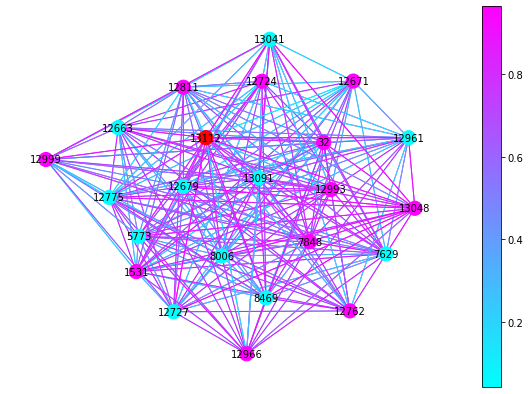

In [32]:
#all edges colored by their mask score
ax1 = visualize_custom(node_idx, hum_graph.edge_index, edge_mask, hum_graph.y,
                 labs=True, cmap_code='cool', plot_central=False, exp_thresh=0.)

As expected . . . a hairball. Let's try setting a threshold.

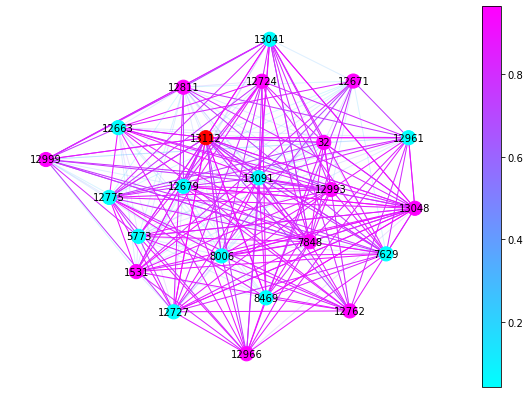

In [33]:
#edges above a threshold, colored by mask score
thresh = 0.5
ax1 = visualize_custom(node_idx, hum_graph.edge_index, edge_mask, hum_graph.y,
                 labs=True, plot_central=False, exp_thresh=thresh)

How about a higher threshold

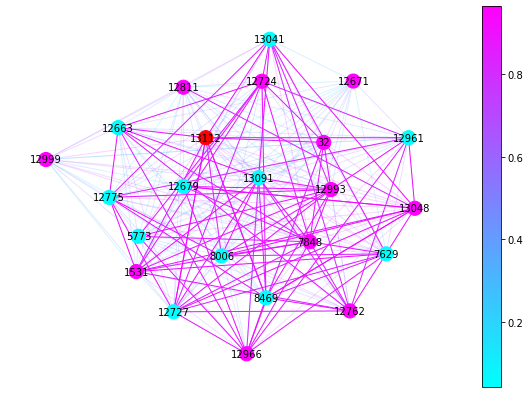

In [35]:
#edges above a higher threshold, colored by mask score
thresh = 0.9
ax1 = visualize_custom(node_idx, hum_graph.edge_index, edge_mask, hum_graph.y,
                 labs=True, plot_central=False, exp_thresh=thresh)

So you can see that you need to set quite a high threshold to start seeing indvidual edges. That really goes to show how dense the graph is. Each node the explained node is connected to, is also connected to every other node in the subgraph. This shows that this dataset might require some more processing to enable meaningful analysis in this way.

Another option is to just plot the edges connected to the central node. 

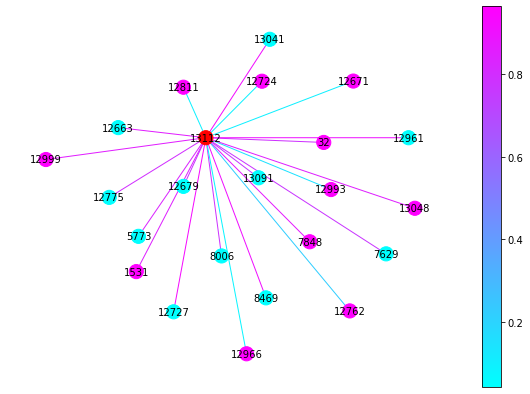

In [36]:
#ensure to set the threshold to 0 so all the edges are plotted according
#to their score
ax1 = visualize_custom(node_idx, hum_graph.edge_index, edge_mask, hum_graph.y,
                 labs=True, plot_central=True, exp_thresh=0.)

From this we can see that not all of the nodes connected to the explained node have high scores.

Some, like node 1293, have a low scoring edge to the explained node. However, looking at the previous plot, we see that there are edges between 1293 and other nodes that do have high scoring edges to the explained node (eg. 1293 -> 12961 -> 13112 (explained node). So this suggests that this nodes information still must be propagated to the explained node. So even though its direct connection is not important, its information is still needed for the prediction.

Contrastingly, looking at node 12811, the edge between it and the explained node is low scoring. Furthermore, looking at the previous plot we see that all edges connected to 12811 are below the threshold. Indeed at this high thresh, every node is still included in the subgraph except 12811, 12999 and 12671. Perhaps this means these are needed less to make a prediction for the explained node.

## Conclusions:

In this way, sub graph explanations can be used to try and determine what nodes are needed for a particular node's explanation. Layering on biological knowledge about these proteins could elucidate something about its function. 

While there are things about this dataset in particular that make explanations difficult (eg. its density, its pre-processing), I hope the ideas presented in this tutorial have demonstrated the utility of GNNExplainer and, more generally, Explainability methods for the application of GNNs for biomedical data. 

References:

1. Ashburner, M. et al. Gene ontology: Tool for the unification of biology. Nature Genetics vol. 25 25–29 (2000).
2. Szklarczyk, D. et al. STRING v11: Protein-protein association networks with increased coverage, supporting functional discovery in genome-wide experimental datasets. Nucleic Acids Res. 47, D607–D613 (2019).
3. Ying, R., Bourgeois, D., You, J., Zitnik, M. & Leskovec, J. GNNExplainer: Generating Explanations for Graph Neural Networks. arXiv (2019).
4. Fey, M. & Lenssen, J. E. Fast Graph Representation Learning with PyTorch Geometric. arXiv (2019).
5. Hu, W. et al. Open Graph Benchmark: Datasets for Machine Learning on Graphs. arXiv (2020).


Further Readings:

1. Jiménez-Luna, J., Grisoni, F. & Schneider, G. Drug discovery with explainable artificial intelligence. Nature Machine Intelligence vol. 2 573–584 (2020).
2. Huang, Q. et al. GraphLIME: Local Interpretable Model Explanations for Graph Neural Networks. arXiv (2020).
3. Vu, M. N. & Thai, M. T. PGM-Explainer: Probabilistic Graphical Model Explanations for Graph Neural Networks. arXiv (2020).